In [1]:
import torch 
import torch.nn as nn
import os
import time
import importlib
import json
from collections import OrderedDict
import logging
import argparse
import numpy as np 
import random
import time
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
import torch.backends.cudnn
import torchvision.utils
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

import torchvision.transforms as transforms
import torchvision

**SIMPLE VGG ARCHITECTURE **

In [86]:
architecture = [64 , 64 , -1 , 128 , 128 , -1 , 256 , 256, 256 , -1, 512, 512, 512 , -1 , 512 ,512, 512,-1]
class VGG(nn.Module):
   def __init__(self,in_channels=3,num_classes=10):
    super(VGG,self).__init__()
    self.in_channels = in_channels
    self.mai = self.main_architecture(architecture)
    self.fcs = nn.Sequential(nn.Linear(7*7*512,4096),
                            nn.ReLU(),
                            nn.Dropout(p=0.5),
                            nn.Linear(4096,4096),
                            nn.ReLU(),
                            nn.Dropout(p=0.5),
                            nn.Linear(4096,num_classes))                               
   def forward(self,x):
     x = self.mai(x)
     x = x.reshape(x.shape[0], -1)
     x = self.fcs(x)
     return x 
   def main_architecture(self,architecture):
            blocks = []
            in_channels = self.in_channels
            for layer in architecture:
                      if layer != -1 : 
                        out_channels = layer
                        blocks+=[nn.Conv2d(in_channels=in_channels,out_channels = out_channels , kernel_size = (3,3) , stride =(1,1) ,padding = (1,1) ),nn.BatchNorm2d(layer),nn.ReLU()]
                        in_channels = layer 
                      elif layer == -1 :
                        blocks+=[(nn.MaxPool2d(kernel_size=(2,2),stride= (2,2)))]
            return nn.Sequential(*blocks)

  

MAIN REPVGG Apart from main architecture specification I have also included identity and RELU as they were suggested for reparamatization in later half of paper also I have not included addition of Identity& ACB for Reparameterization


In [43]:


class REPVGG(nn.Module):
   def __init__(self,in_channels=3,num_classes=10,num_blocks=None,width_multiplier=None):
    super(REPVGG,self).__init__()
    self.num_blocks = num_blocks
    self.width_multiplier= width_multiplier 
    self.in_channels = in_channels
    self.main_REPVGG = self.main_architecture()
    self.gap = nn.AdaptiveAvgPool2d(output_size=1)
    self.linear = nn.Linear(int(512 * width_multiplier[3]), num_classes)                               
   
   def main_architecture(self):
            blocks = []


            #stage0
            width_multiplier = self.width_multiplier
            out_channels = min(64,int(64*width_multiplier[0])) 
            in_channels = self.in_channels
            num_blocks = self.num_blocks
            blocks += [nn.Conv2d(in_channels = in_channels,out_channels=out_channels,kernel_size=(3,3),stride=(2,2),padding=(1,1)),nn.BatchNorm2d(num_features=out_channels),nn.Identity(),nn.ReLU()]
            in_channels = min(64, int(64*width_multiplier[0]))




            #s1,s2,s3,s4



            for i in range(4):

              out_channels = int(64*(2**i) * width_multiplier[i])
              blocks += [nn.Conv2d(in_channels = in_channels,out_channels=out_channels,kernel_size=(3,3),stride=(2,2),padding=(1,1)),nn.BatchNorm2d(num_features=int(64*(2**i) * width_multiplier[i])),nn.Identity(),nn.ReLU()]
              in_channels = out_channels

              for j in range(num_blocks[i]-1):
                blocks += [nn.Conv2d(in_channels = in_channels,out_channels=out_channels,kernel_size=(3,3),stride=(1,1),padding=(1,1)),nn.BatchNorm2d(num_features=out_channels),nn.Identity(),nn.ReLU()]
              in_channels = out_channels 

            return nn.Sequential(*blocks)

   def forward(self,x):
     x = self.main_REPVGG(x)
     x = x.view(x.size(0), -1)
     x = self.linear(x)
     return x 


In [4]:
transform = transforms.Compose([transforms.Pad(4),transforms.RandomHorizontalFlip(),transforms.RandomCrop(32),transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
test_transform  = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='../../data/', train=True,transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='../../data/', train=False,transform=test_transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=100, shuffle=False)


Extracting ../../data/cifar-10-python.tar.gz to ../../data/


### **DIFFERENT TYPES OF REPVGG I have only implemented B2 since according to paper it giver best top1 accuracy all other can be implemented just by changing the arguments  **

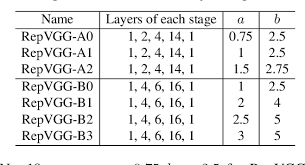

In [45]:
depth = 2
epochs = 8
batch_size = 128
base_lr = 0.01
lr_decay = 0.1
milestones = '[80, 120]'
device = "cuda"
num_workers = 3

model = REPVGG(in_channels=3,num_classes=10,num_blocks=[4, 6, 16, 1],width_multiplier=[2.5, 2.5, 2.5, 5]).to(device)
#model = VGG(in_channels = 3, num_classes = 10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=base_lr)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=lr_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=lr_decay)
for epoch in range(epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % 50 == 0:
      print ("Epoch {}, Step {} Loss: {:.4f}".format(epoch+1, i+1, loss.item()))   
  scheduler.step()

Epoch 1, Step 50 Loss: 2.6057
Epoch 1, Step 100 Loss: 2.9974
Epoch 1, Step 150 Loss: 2.8768
Epoch 1, Step 200 Loss: 2.2815
Epoch 1, Step 250 Loss: 2.6750
Epoch 1, Step 300 Loss: 2.2841
Epoch 1, Step 350 Loss: 3.3047
Epoch 1, Step 400 Loss: 2.7760
Epoch 1, Step 450 Loss: 2.7409
Epoch 1, Step 500 Loss: 2.2934
Epoch 2, Step 50 Loss: 2.3203
Epoch 2, Step 100 Loss: 2.3110
Epoch 2, Step 150 Loss: 2.2558
Epoch 2, Step 200 Loss: 2.2738
Epoch 2, Step 250 Loss: 2.2876
Epoch 2, Step 300 Loss: 2.2735
Epoch 2, Step 350 Loss: 2.3000
Epoch 2, Step 400 Loss: 2.2480
Epoch 2, Step 450 Loss: 2.2753
Epoch 2, Step 500 Loss: 2.3052
Epoch 3, Step 50 Loss: 2.3056
Epoch 3, Step 100 Loss: 2.1300
Epoch 3, Step 150 Loss: 2.0371
Epoch 3, Step 200 Loss: 2.0552
Epoch 3, Step 250 Loss: 1.9889
Epoch 3, Step 300 Loss: 1.9380
Epoch 3, Step 350 Loss: 1.9737
Epoch 3, Step 400 Loss: 1.9292
Epoch 3, Step 450 Loss: 2.0064
Epoch 3, Step 500 Loss: 1.9019
Epoch 4, Step 50 Loss: 1.8022
Epoch 4, Step 100 Loss: 1.9061
Epoch 4, Ste

In [46]:
model.eval

<bound method Module.eval of REPVGG(
  (main_REPVGG): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(16

# IN 8 EPOCHS IT IS GIVING POOR ACCURACY I NEED TO HAVE BETTER DEVICE FOR 200 EPOCHS AS SUGGESTED IN PAPER 

In [47]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy ( test images ) : {} %'.format(100 * correct / total))

Accuracy ( test images ) : 31.57 %
